In [56]:
# dataset from https://www.investing.com/equities/baladna-food-industries-co-historical-data

In [57]:
import pandas as pd

df = pd.read_csv('BLDN.csv')

df

,Date,Price,Open,High,Low,Vol.,Change %
0,05/06/2025,1.21,1.22,1.23,1.21,12.26M,-0.74%
1,05/05/2025,1.22,1.21,1.23,1.21,10.47M,0.83%
2,05/04/2025,1.21,1.23,1.23,1.21,13.70M,-0.90%
3,05/01/2025,1.22,1.21,1.23,1.21,13.69M,0.82%
4,04/30/2025,1.21,1.22,1.22,1.21,11.55M,-0.82%
...,...,...,...,...,...,...,...
1334,12/22/2019,0.95,0.95,0.96,0.95,10.00M,0.00%
1335,12/17/2019,0.95,0.95,0.96,0.95,4.62M,0.00%
1336,12/16/2019,0.95,0.95,0.96,0.95,5.26M,0.00%
1337,12/15/2019,0.95,0.95,0.96,0.95,7.92M,0.00%


In [58]:
df = df[['Date','Price']]

df

,Date,Price
0,05/06/2025,1.21
1,05/05/2025,1.22
2,05/04/2025,1.21
3,05/01/2025,1.22
4,04/30/2025,1.21
...,...,...
1334,12/22/2019,0.95
1335,12/17/2019,0.95
1336,12/16/2019,0.95
1337,12/15/2019,0.95


In [59]:
df['Date']

,Date
0,05/06/2025
1,05/05/2025
2,05/04/2025
3,05/01/2025
4,04/30/2025
...,...
1334,12/22/2019
1335,12/17/2019
1336,12/16/2019
1337,12/15/2019


In [60]:
import datetime

df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')  # Convert to datetime
df.set_index('Date', inplace=True)                         # Set as index

df

<ipython-input-60-850d12b34656>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')  # Convert to datetime


,Price
Date,
2025-05-06,1.21
2025-05-05,1.22
2025-05-04,1.21
2025-05-01,1.22
2025-04-30,1.21
...,...
2019-12-22,0.95
2019-12-17,0.95
2019-12-16,0.95


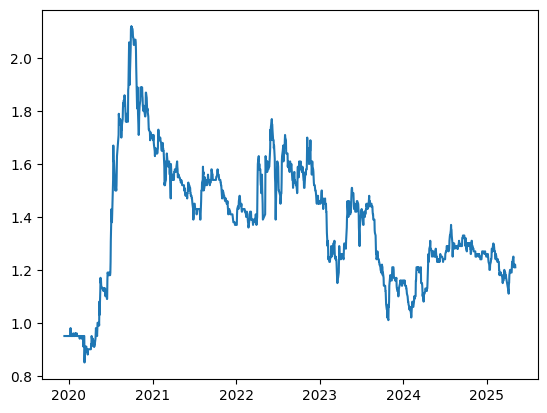

In [61]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Price'])

In [62]:
print(df.columns)


Index(['Price'], dtype='object')


In [63]:
import numpy as np
import pandas as pd

def str_to_datetime(date_str):
    return datetime.datetime.strptime(date_str, "%Y-%m-%d")

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):

    first_date = str_to_datetime(first_date_str)
    last_date  = str_to_datetime(last_date_str)

    target_date = first_date
    dates = []
    X, Y = [], []

    while True:
        df_subset = dataframe.loc[:target_date].tail(n + 1)

        if len(df_subset) != n + 1:
            # Just skip this date and move to the next
            if target_date.weekday() == 4:
                next_date = target_date + datetime.timedelta(days=3)
            else:
                next_date = target_date + datetime.timedelta(days=1)
            if next_date > last_date:
                break
            target_date = next_date
            continue

        values = df_subset['Price'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        # Advance to next date (skip weekends)
        if target_date.weekday() == 4:
            next_date = target_date + datetime.timedelta(days=3)
        else:
            next_date = target_date + datetime.timedelta(days=1)

        if next_date > last_date:
            break

        target_date = next_date

    ret_df = pd.DataFrame({'Target Date': dates})
    X = np.array(X)
    for i in range(n):
        ret_df[f'Target-{n - i}'] = X[:, i]
    ret_df['Target'] = Y
    return ret_df

windowed_df = df_to_windowed_df(df, '2019-12-16', '2025-05-06', n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2019-12-16,0.95,0.95,0.95,0.95
1,2019-12-17,0.95,0.95,0.95,0.95
2,2019-12-18,0.95,0.95,0.95,0.95
3,2019-12-19,0.95,0.95,0.95,0.95
4,2019-12-20,0.95,0.95,0.95,0.95
...,...,...,...,...,...
1399,2025-04-25,1.21,1.22,1.25,1.25
1400,2025-04-28,1.22,1.21,1.22,1.25
1401,2025-04-29,1.21,1.22,1.21,1.22
1402,2025-04-30,1.22,1.21,1.22,1.21


In [64]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:,0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((1404,), (1404, 3, 1), (1404,))

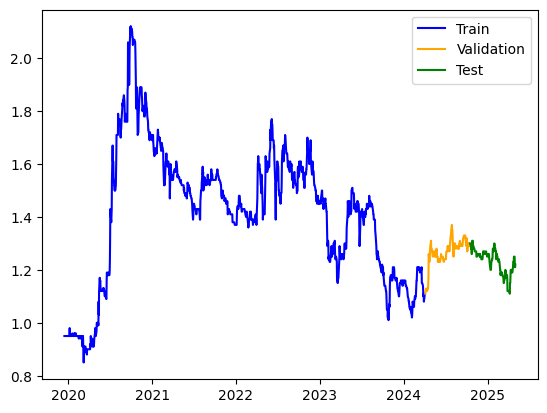

In [65]:
q_80 = int(len(dates) * 0.8)
q_90 = int(len(dates) * 0.9)

# Proper slicing — keep ranges aligned
dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

# Plot with distinct colors
plt.plot(dates_train, y_train, label='Train', color='blue')
plt.plot(dates_val, y_val, label='Validation', color='orange')
plt.plot(dates_test, y_test, label='Test', color='green')

plt.legend()
plt.show()


In [66]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

# Reshape input for LSTM: [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# LSTM Model
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, activation='relu', input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.Dense(1)
])

model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50
)



Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 1.6928 - val_loss: 0.5170
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3869 - val_loss: 0.0078
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0097 - val_loss: 0.0014
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0026 - val_loss: 0.0010
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0023 - val_loss: 9.8955e-04
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020 - val_loss: 9.8146e-04
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0023 - val_loss: 7.9347e-04
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021 - val_loss: 9.8159e-04
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020 - val_loss: 7.6883e-04
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021 - val_loss: 6.0122e-04
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019 - val_loss: 4.7374e-04
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - 

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


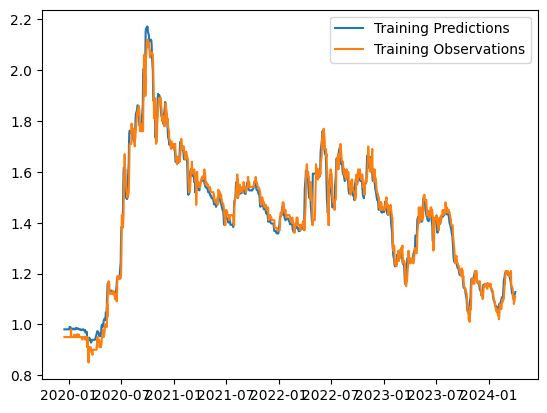

In [67]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


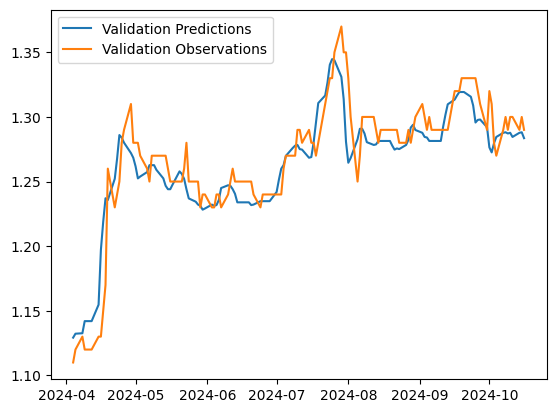

In [68]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


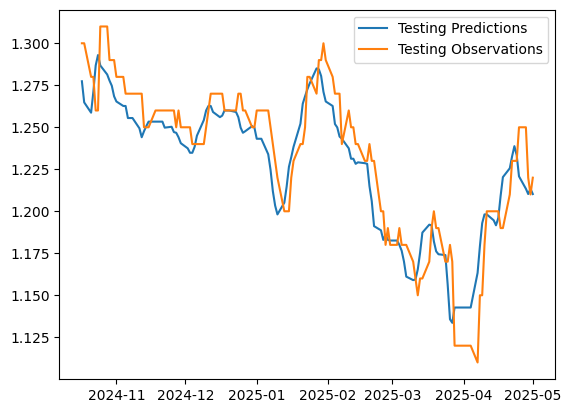

In [69]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

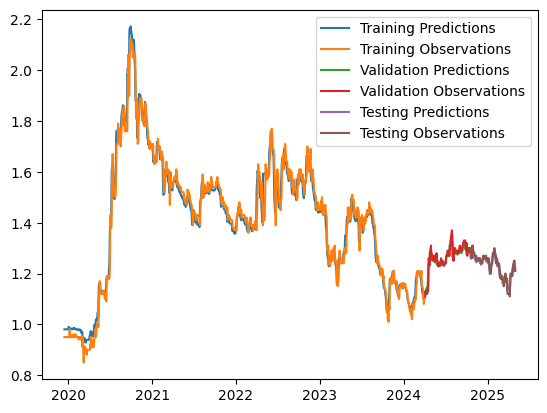

In [70]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

In [76]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

# Start with the last training window, reshaped for LSTM input (timesteps, features)
last_window = deepcopy(X_train[-1])  # shape (timesteps, 1)

for target_date in recursive_dates:
    # Predict next value, input shape (1, timesteps, features)
    next_prediction = model.predict(last_window[np.newaxis, :, :]).flatten()[0]

    recursive_predictions.append(next_prediction)

    # Update last_window by shifting left and adding new prediction at the end
    last_window = np.roll(last_window, -1)  # shift all values one step left
    last_window[-1] = next_prediction       # replace last timestep with prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

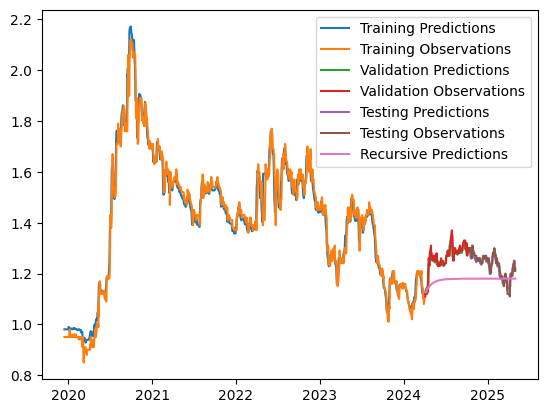

In [77]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])

In [78]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("Train MAE:", mean_absolute_error(y_train, train_predictions))
print("Val MAE:", mean_absolute_error(y_val, val_predictions))
print("Test MAE:", mean_absolute_error(y_test, test_predictions))


Train MAE: 0.029767539352178574
Val MAE: 0.015126470476388931
Test MAE: 0.014849749393761158


Text(0, 0.5, 'Frequency')

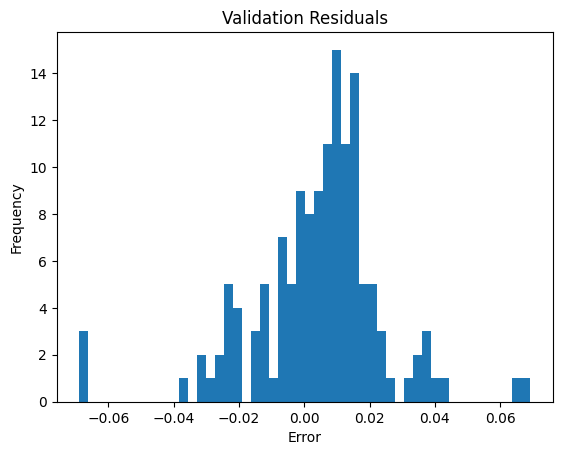

In [79]:
plt.hist(y_val - val_predictions, bins=50)
plt.title("Validation Residuals")
plt.xlabel("Error")
plt.ylabel("Frequency")


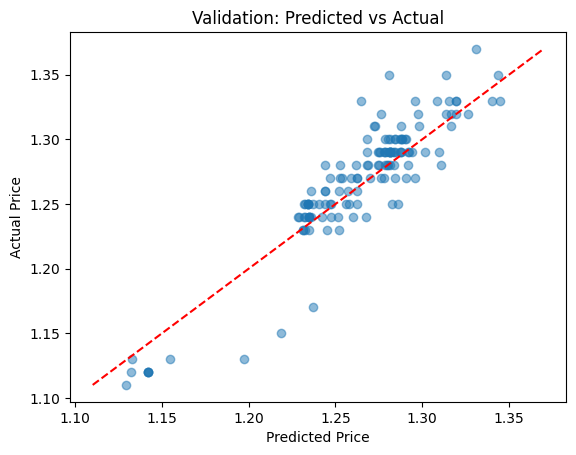

In [80]:
plt.scatter(val_predictions, y_val, alpha=0.5)
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Validation: Predicted vs Actual')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--')
